<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/mnist-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

## Define the VAE as a `Model` with a custom `train_step`

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

# Train a classifier

In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

classifier = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax"),
])

classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
classifier.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 7s 6ms/step - loss: 0.3370 - accuracy: 0.8974 - val_loss: 0.0857 - val_accuracy: 0.9744
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1075 - accuracy: 0.9665 - val_loss: 0.0555 - val_accuracy: 0.9828
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0810 - accuracy: 0.9755 - val_loss: 0.0435 - val_accuracy: 0.9859
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0695 - accuracy: 0.9782 - val_loss: 0.0399 - val_accuracy: 0.9866
Epoch 5/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0599 - accuracy: 0.9810 - val_loss: 0.0365 - val_accuracy: 0.9878
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0542 - accuracy: 0.9836 - val_loss: 0.0322 - val_accuracy: 0.9888
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 0.0517 - accuracy: 0.9839 - val_loss: 0.0321 - val_accuracy: 0.9885
Epoch 

## Display a grid of sampled digits

100%|██████████| 21/21 [00:45<00:00,  2.18s/it]


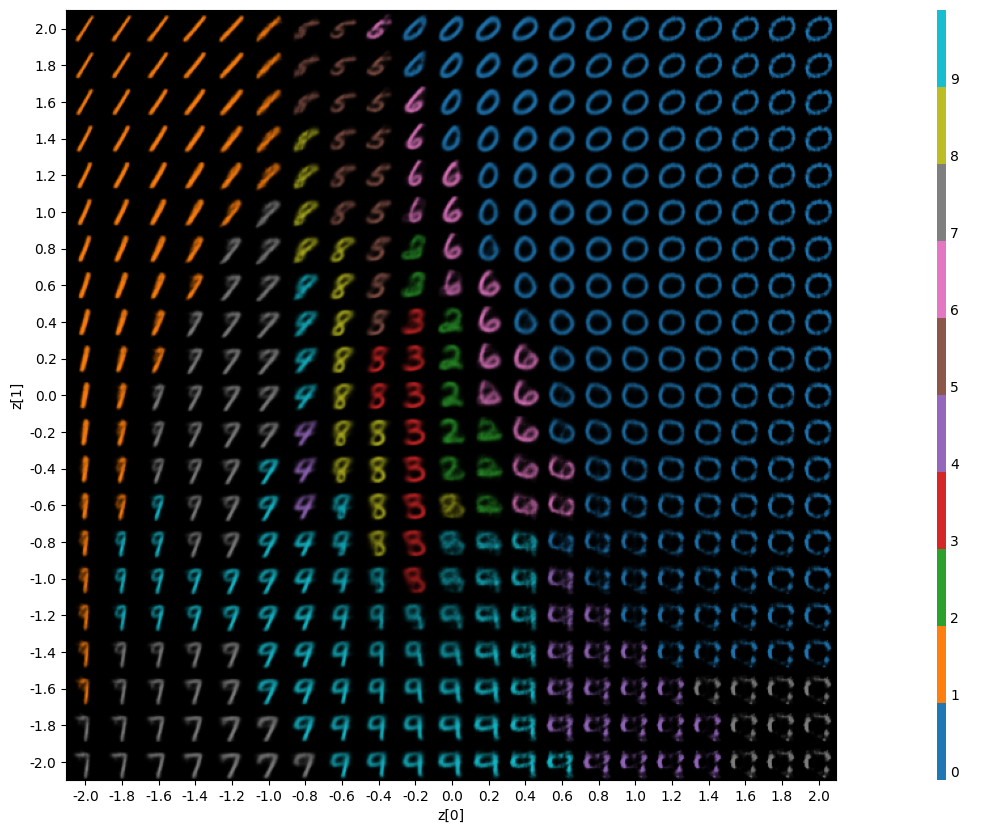

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import numpy as np
import matplotlib.patches as patches

def plot_latent_space(vae, classifier, n=21, figsize=10):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 2
    figure = np.zeros((digit_size * n, digit_size * n, 3))


    # Define colors for labels 0 to 9; you can use custom colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    colors = [
        [float(x)/255 for x in list(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))]
        for c in colors
    ]

    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in tqdm(list(enumerate(grid_y))):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=False)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # figure[
            #    i * digit_size : (i + 1) * digit_size,
            #    j * digit_size : (j + 1) * digit_size,
            #    :
            #] = np.expand_dims(digit, axis=-1)


                    # Predict label
            reshaped_digit = np.expand_dims(np.expand_dims(digit, axis=-1), axis=0)
            predicted_label = classifier.predict(reshaped_digit, verbose=False).argmax(axis=-1)[0]

            #  predicted_label = classifier.predict(digit).argmax(axis=-1)[0]

            color = colors[predicted_label]

            for channel in range(3):
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                    channel
                ] = digit * color[channel]

    fig, ax = plt.subplots(1, 2, figsize=(figsize + 2, figsize), gridspec_kw={'width_ratios': [19, 1]})

    # Draw main plot
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax[0].imshow(figure)
    ax[0].set_xticks(pixel_range)
    ax[0].set_yticks(pixel_range)
    ax[0].set_xticklabels(sample_range_x)
    ax[0].set_yticklabels(sample_range_y)
    ax[0].set_xlabel("z[0]")
    ax[0].set_ylabel("z[1]")

    # Draw legend
    rect_height = 0.2  # Smaller height
    for i, color in enumerate(colors):

        rect = patches.Rectangle((0, i * rect_height), rect_height, rect_height, linewidth=1, edgecolor='none', facecolor=color)
        ax[1].add_patch(rect)
        ax[1].text(0.3, i * rect_height, f'{i}', verticalalignment='bottom', fontsize=10)  # Smaller fontsize and closer to the rectangle

    ax[1].set_xlim(0, 1)  # Smaller width
    ax[1].set_ylim(0, len(colors) * rect_height)  # Height according to the number of labels
    ax[1].axis('off')


    plt.show()


plot_latent_space(vae, classifier)

100%|██████████| 21/21 [00:51<00:00,  2.45s/it]


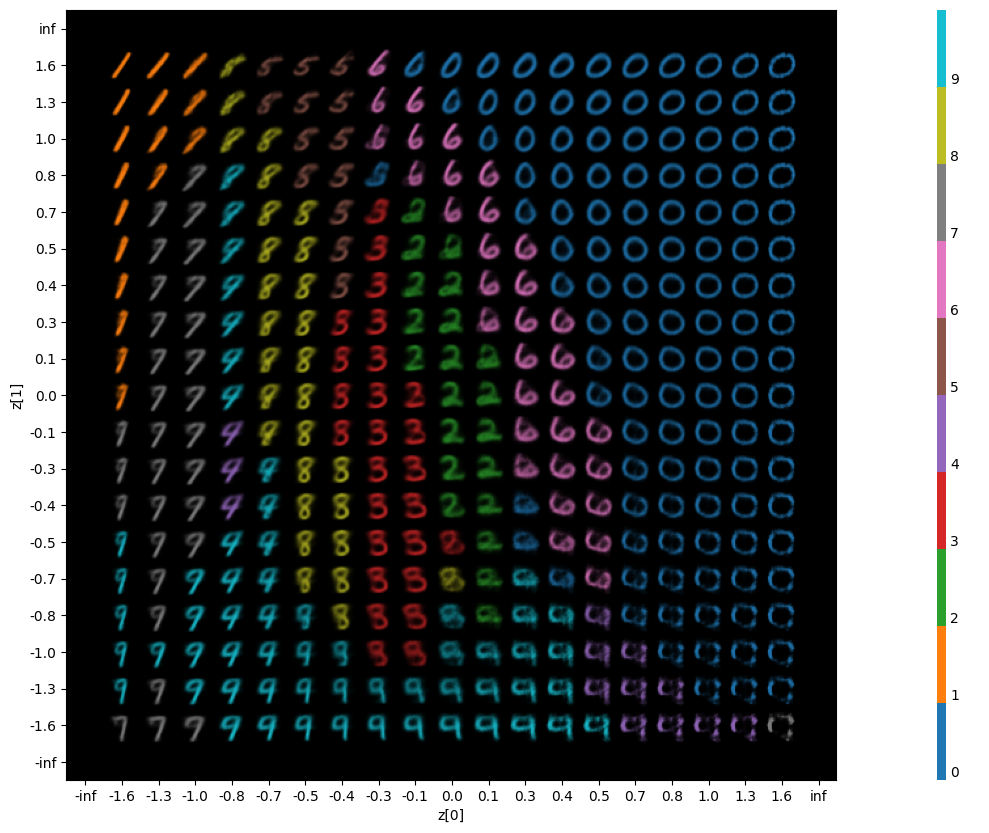

In [60]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import numpy as np
import matplotlib.patches as patches
from scipy.stats import norm

def plot_latent_space(vae, classifier, n=21, figsize=10):
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n, 3))

    colors = list(mcolors.TABLEAU_COLORS.values())
    colors = [[float(x)/255 for x in list(int(c.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))] for c in colors]

    # linearly spaced coordinates corresponding to quantiles
    grid_quantile_x = np.linspace(0, 1, n)
    grid_quantile_y = np.linspace(0, 1, n)[::-1]

    # transform quantiles to z-values
    grid_x = norm.ppf(grid_quantile_x)
    grid_y = norm.ppf(grid_quantile_y)

    for i, yi in tqdm(list(enumerate(grid_y))):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=False)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # Predict label
            reshaped_digit = np.expand_dims(np.expand_dims(digit, axis=-1), axis=0)
            predicted_label = classifier.predict(reshaped_digit, verbose=False).argmax(axis=-1)[0]

            color = colors[predicted_label]
            for channel in range(3):
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                    channel
                ] = digit * color[channel]

    fig, ax = plt.subplots(1, 2, figsize=(figsize + 2, figsize), gridspec_kw={'width_ratios': [19, 1]})

    # Draw main plot
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    ax[0].imshow(figure)
    ax[0].set_xticks(pixel_range)
    ax[0].set_yticks(pixel_range)
    ax[0].set_xticklabels(sample_range_x)
    ax[0].set_yticklabels(sample_range_y)
    ax[0].set_xlabel("z[0]")
    ax[0].set_ylabel("z[1]")

    # Draw legend
    rect_height = 0.2
    for i, color in enumerate(colors):
        rect = patches.Rectangle((0, i * rect_height), rect_height, rect_height, linewidth=1, edgecolor='none', facecolor=color)
        ax[1].add_patch(rect)
        ax[1].text(0.3, i * rect_height, f'{i}', verticalalignment='bottom', fontsize=10)

    ax[1].set_xlim(0, 1)
    ax[1].set_ylim(0, len(colors) * rect_height)
    ax[1].axis('off')

    plt.show()

plot_latent_space(vae, classifier)


## Display how the latent space clusters different digit classes

1875/1875 [==============================] - 4s 2ms/step


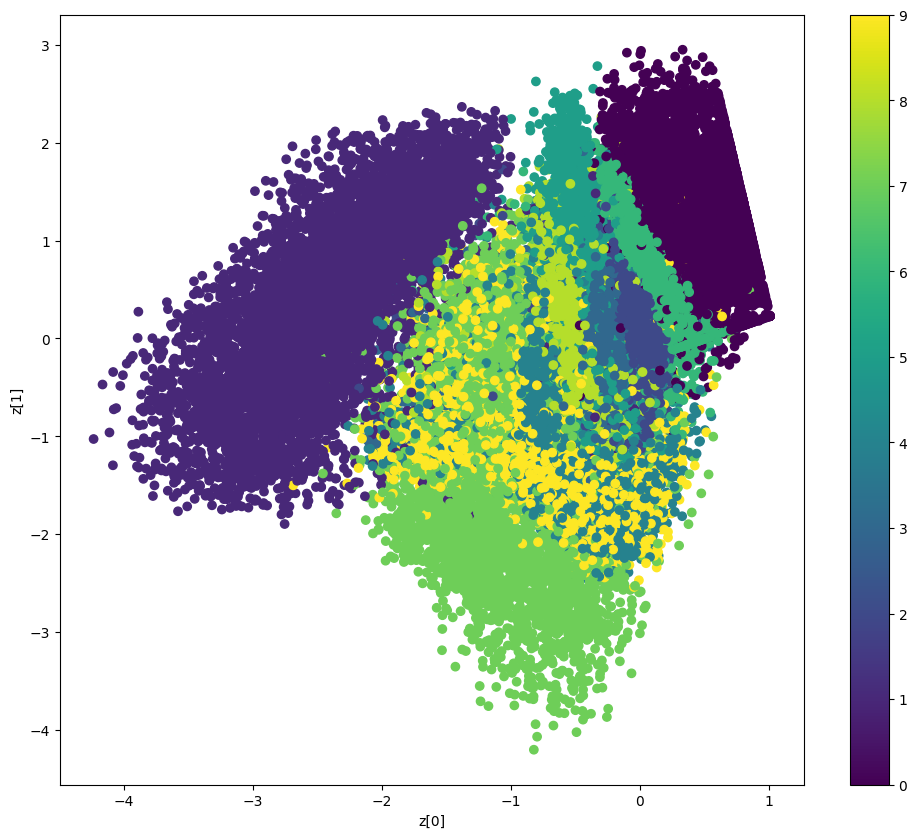

In [15]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [61]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [65]:
import pandas as pd

pd.Series(y_train).value_counts() / len(y_train)


1    0.112367
7    0.104417
3    0.102183
2    0.099300
9    0.099150
0    0.098717
6    0.098633
8    0.097517
4    0.097367
5    0.090350
dtype: float64